In [57]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
dataset = pd.read_csv(
    "F:\Data_Science\WA_Fn-UseC_-Telco-Customer-Churn.csv",
    header = 0
)

In [166]:
dataset.replace(
    to_replace = ["No","Yes","No phone service","No internet service","Male","Female","DSL","Fiber optic","Electronic check","Mailed check","Bank transfer (automatic)","Credit card (automatic)","Month-to-month","One year","Two year",' '],
    value = [1,2,0,0,2,1,2,3,1,2,3,4,1,2,3,0],
    inplace = True
)

In [167]:
dataset = dataset.iloc[:,1:dataset.shape[1]]

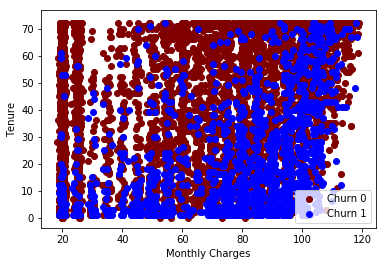

In [169]:
x = dataset.iloc[:,0:dataset.shape[1]-1]
y = dataset['Churn']

plt.scatter(x[y==1]['MonthlyCharges'], x[y==1]['tenure'], label='Churn 0', c='maroon')
plt.scatter(x[y==2]['MonthlyCharges'], x[y==2]['tenure'], label='Churn 1', c='blue')

plt.legend()
plt.xlabel('Monthly Charges')
plt.ylabel('Tenure')

plt.show()

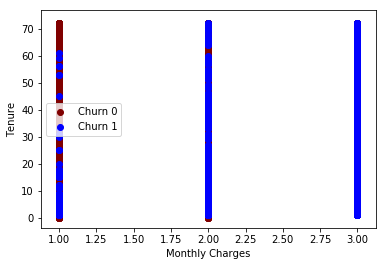

In [170]:
x = dataset.iloc[:,0:dataset.shape[1]-1]
y = dataset['Churn']

plt.scatter(x[y==1]['InternetService'], x[y==1]['tenure'], label='Churn 0', c='maroon')
plt.scatter(x[y==2]['InternetService'], x[y==2]['tenure'], label='Churn 1', c='blue')

plt.legend()
plt.xlabel('Monthly Charges')
plt.ylabel('Tenure')

plt.show()

In [171]:
from sklearn import preprocessing

In [172]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(dataset)
datasetEdit = pd.DataFrame(np_scaled)

C:\Users\hp\Anaconda3\envs\TensorFlowEnv\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Building the ML Model

In [210]:
X = datasetEdit.iloc[:,0:datasetEdit.shape[1]-1]
Y = datasetEdit.iloc[:,datasetEdit.shape[1]-1:datasetEdit.shape[1]]

In [219]:
import math

X_train = X.iloc[0:math.ceil(X.shape[0]*0.89),:]
Y_train = Y.iloc[0:math.ceil(Y.shape[0]*0.89),:]

X_test = X.iloc[math.ceil(X.shape[0]*0.89):X.shape[0],:]
Y_test = Y.iloc[math.ceil(Y.shape[0]*0.89):Y.shape[0],:]

In [220]:
print("Number of Training Examples: "+str(X_train.shape[0]))
print("Number of Features: "+str(X_train.shape[1]))
print("Shape of Input Training Vector X: "+str(X_train.shape))
print("Shape of Output Training Vector Y: "+str(Y_train.shape))

print("Number of Testing Examples: "+str(X_test.shape[0]))
print("Shape of Input Testing Vector X: "+str(X_test.shape))
print("Shape of Output Testing Vector Y: "+str(Y_test.shape))

Number of Training Examples: 6269
Number of Features: 19
Shape of Input Training Vector X: (6269, 19)
Shape of Output Training Vector Y: (6269, 1)
Number of Testing Examples: 774
Shape of Input Testing Vector X: (774, 19)
Shape of Output Testing Vector Y: (774, 1)


In [221]:
def create(n_x,n_y):
    X = tf.placeholder(tf.float32,[None,n_x],name='X')
    Y = tf.placeholder(tf.float32,[None,n_y],name='Y')
    
    return X,Y

In [222]:
def parameters():
    
    W1 = tf.get_variable("W1", [19, 6],dtype=tf.float32, initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [1, 6],dtype=tf.float32, initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [6, 2],dtype=tf.float32, initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [1, 2],dtype=tf.float32, initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 1],dtype=tf.float32, initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [1, 1],dtype=tf.float32, initializer = tf.zeros_initializer())
    
    parSet = {
        "W1": W1,
        "b1": b1,
        "W2":W2,
        "b2":b2,
        "W3":W3,
        "b3":b3
    }
    
    return parSet

In [223]:
def forprop(X,parSet):
    
    Z1 = tf.add(tf.matmul(X,parSet['W1']), parSet['b1'])
    
    Z2 = tf.add(tf.matmul(Z1,parSet['W2']), parSet['b2'])
    A2 = tf.nn.tanh(Z2)
    
    Z3 = tf.add(tf.matmul(A2,parSet['W3']), parSet['b3'])
    A3 = tf.nn.sigmoid(Z3)
        
    return A3

In [224]:
def cost_value(Z3,Y):
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.losses.mean_squared_error(predictions=logits,labels=labels))
    
    return cost

In [225]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.0085,epoches=2000,batch_size=32):
    
    tf.reset_default_graph()
    
    (m,n_x) = X_train.shape
    n_y = Y_train.shape[1]
    
    costs = []
    accuracy = []
    X, Y = create(n_x, n_y)
    parSet = parameters()
    A4 = forprop(X, parSet)
    cost = cost_value(A4, Y)
    
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, 750, 0.99, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(epoches):
            
            epoch_cost = 0
            batches = int(m/batch_size)
            
            for j in range(batches):
                
                start = j*batch_size
                end = (j+1)*batch_size
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: X_train.iloc[start:end,:], Y: Y_train.iloc[start:end,:]})
                
                epoch_cost += minibatch_cost / batches
                
            if epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                    
        print ("Cost after epoch 2000: %f" % (epoch_cost))
                    
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.show()
        
        parSet = sess.run(parSet)
        correct_prediction = tf.equal(tf.round(A4), Y)
          
        accuracy = tf.scalar_mul(100,tf.reduce_mean(tf.cast(correct_prediction, "float")))
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parSet

Cost after epoch 0: 0.160662
Cost after epoch 100: 0.134122
Cost after epoch 200: 0.132900
Cost after epoch 300: 0.132561
Cost after epoch 400: 0.133123
Cost after epoch 500: 0.133942
Cost after epoch 600: 0.132585
Cost after epoch 700: 0.133009
Cost after epoch 800: 0.132509
Cost after epoch 900: 0.134373
Cost after epoch 1000: 0.133224
Cost after epoch 1100: 0.133686
Cost after epoch 1200: 0.134744
Cost after epoch 1300: 0.133448
Cost after epoch 1400: 0.133497
Cost after epoch 1500: 0.132981
Cost after epoch 1600: 0.132948
Cost after epoch 1700: 0.133037
Cost after epoch 1800: 0.135050
Cost after epoch 1900: 0.134152
Cost after epoch 2000: 0.133820


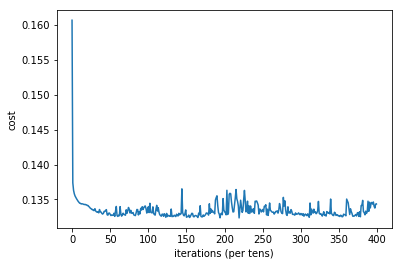

Train Accuracy: 80.874146
Test Accuracy: 80.10336


In [226]:
parameters = model(X_train, Y_train, X_test, Y_test)